## Data analysis

In [1]:
from l_p2 import persistence_length
import matplotlib.pyplot as plt
import numpy as np
import scipy
import MDAnalysis as mda
from MDAnalysis.analysis import polymer
import glob
import pandas as pd
from scipy.stats import linregress
import os
from polymer_dictionary import polymer_dictionary

from pl_com import persistence_length1

ref_length = 0.3563594872561357

/home/jbieri/miniforge3/envs/p_l/lib/python3.11/site-packages/foyer/forcefield.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import iter_entry_points, resource_filename
/home/jbieri/miniforge3/envs/p_l/lib/python3.11/site-packages/pkg_resources/__init__.py:3146: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)



Support for writing out LAMMPS data files will be removed
in mbuild 1.0.
See GMSO (https://github.com/mosdef-hub/gmso/tree/main/gmso/formats/lammpsdata) for
continued support for LAMMPS.



In [2]:
# Getting a sorted list of the 10mer trajectories
key_list = sorted(list(polymer_dictionary.keys())) # Aligning dictionary and path to aid automation
path = os.getcwd() # Non-user specific path
molecule_list = sorted(glob.glob(path+"/gsd_files/10_mers/"+"*_10mer.gsd"))

In [8]:
start = 100
stop = 1600
step = 100
subfolders = [str(i) for i in range(start, stop, step)]
all_mol_list = []
all_mol_list.append(molecule_list)

for subfolder in subfolders:
    folder_path = os.path.join(path, "gsd_files", "10_mers", subfolder)
    molecules = sorted(glob.glob(os.path.join(folder_path, "*.gsd")))
    all_mol_list.append(molecules)


### Calculating persistence lengths:

In [32]:
p_lens = []
exp_fits = []
for mol_list in all_mol_list:
    i = 0
    for filepath in mol_list:
        h = persistence_length(filepath=filepath,
                           atom_index=polymer_dictionary.get(key_list[i]).get("Sulfur index"),
                           monomer_count=10,
                           start=50)
        l_p = h[0]
        # l_b = h[1]
        # x_values = h[2]
        # C_n = h[3]
        exp_fit = h[4]
        # decorr = h[-2]
        i += 1
        p_lens.append(l_p*ref_length*10)
        exp_fits.append(exp_fit)

In [7]:
seeds = [12345] + [i for i in range(start, stop, step)]

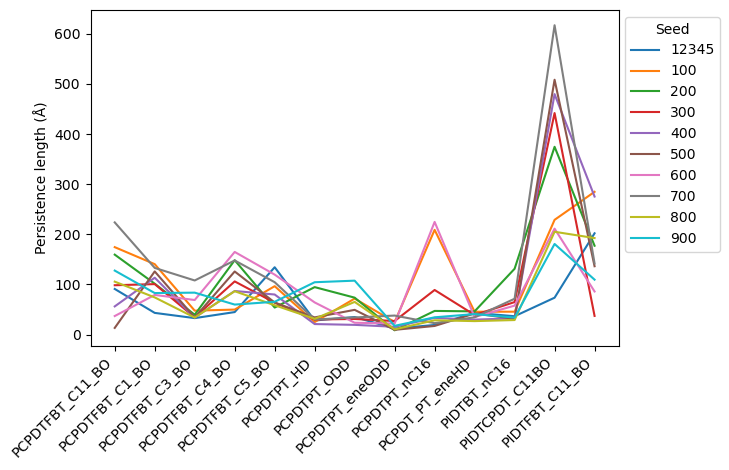

In [340]:
for i in range(len(seeds)):
    plt.plot(key_list,p_lens[i*13:(i+1)*13])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylabel("Persistence length (Å)")
plt.legend(seeds, title="Seed", loc="upper left", bbox_to_anchor=(1, 1))

## Plotting boxplots, independence p-values, and variance

### Boxplots

In [33]:
# Makes a list of each molecule
copy = []
for i in range(len(key_list)):
    copy.append(p_lens[i::13])

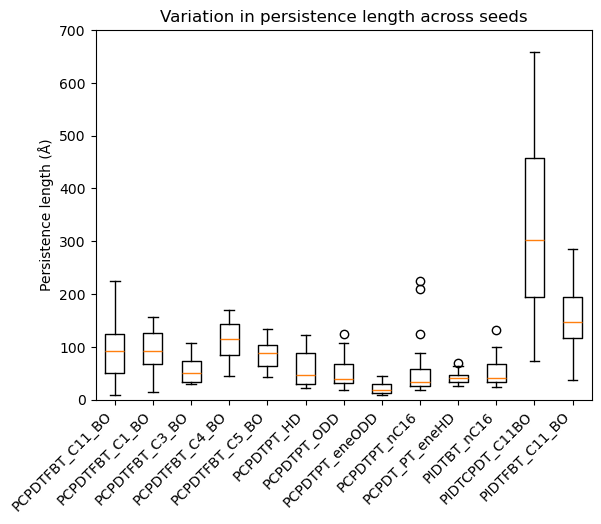

In [34]:
plt.boxplot(copy, tick_labels=key_list)
plt.ylim(0,700)
plt.xticks(rotation=45,ha='right')
plt.title("Variation in persistence length across seeds")
plt.ylabel("Persistence length (Å)")
# plt.savefig("box_plots",bbox_inches='tight', dpi=600)
plt.show()

### Independence

In [35]:
from scipy.stats import kruskal

In [36]:
by_seed = list(zip(*copy))

In [37]:
p_value = kruskal(*by_seed).pvalue

In [38]:
print(p_value)

0.7879375900418836


### Mean persistence length measurement and standard deviation

In [13]:
x = list(range(len(key_list))) 

In [348]:
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [10]:
stdv = []
means = []
for i in range(len(key_list)):
    means.append(np.mean(copy[i]))
    stdv.append(np.std(copy[i], ddof=1))

In [11]:
print(stdv)

[58.98092781569521, 42.23823104315731, 25.234411321113765, 40.29741434675644, 26.0762646978946, 33.823170401486955, 31.004546747827856, 12.127494848574749, 66.18418497477352, 11.740957105668404, 29.692613910035956, 180.51043851111737, 68.86668123075005]


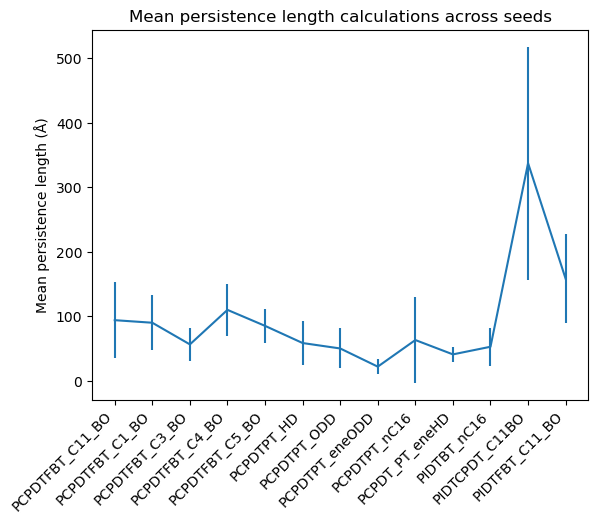

In [23]:
plt.errorbar(x=key_list,y=means,yerr=stdv)
plt.xticks(ticks=x, labels=key_list, rotation=45, ha='right')
plt.title("Mean persistence length calculations across seeds")
plt.ylabel("Mean persistence length (Å)")
# plt.savefig("stdev",bbox_inches='tight', dpi=600)
plt.show()

## Comparison against Danielsen et al. paper

In [15]:
measured_pl = [291, 67.0, 78.4, 86.4, 114, 47.3, 54.9, 83.4, 61.0, 76.6, 1310, 236, 254] # Measured persistence length using SANS (in alphabetical order)

In [328]:
differences = np.array(measured_pl) - np.array(means)

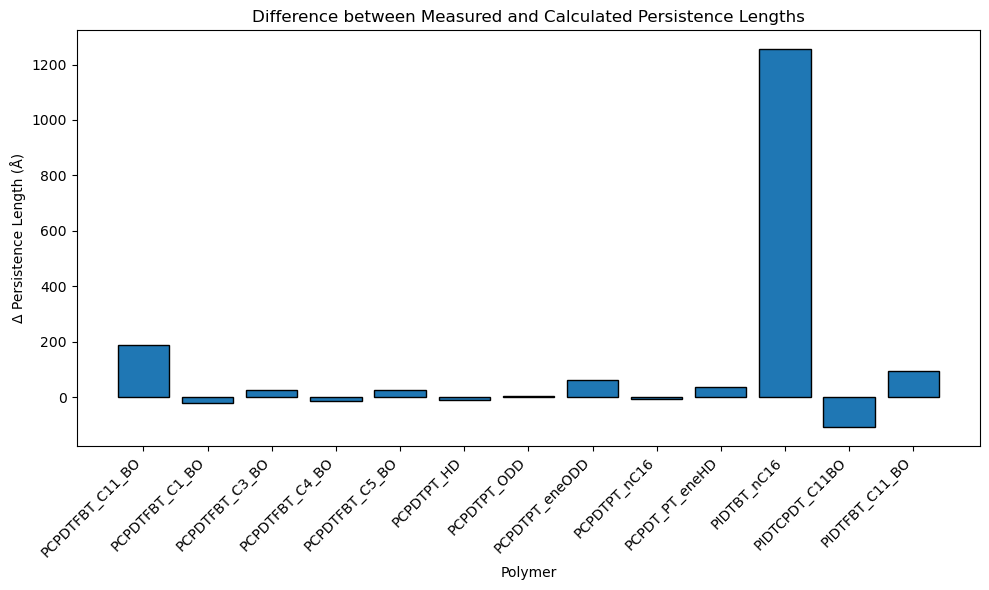

In [389]:
plt.figure(figsize=(10, 6))
plt.bar(key_list[0:len(molecule_list)], differences, edgecolor='black')

plt.xlabel('Polymer')
plt.ylabel('Δ Persistence Length (Å)')
plt.title('Difference between Measured and Calculated Persistence Lengths')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("bar_chart",bbox_inches='tight', dpi=600)
plt.show()

In [400]:
l_p, l_b, x, auto_avg, fit, exp_coeff, acorr, decor, unit_bonds = persistence_length(
    filepath="long_PIDCPDT_C11_run.gsd", 
    atom_index=28,
    monomer_count=10,
    start=0
    # stop=1
)

87.60676634611131


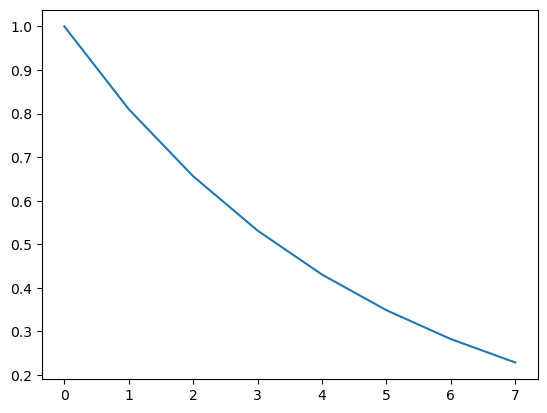

In [401]:
print(l_p*ref_length*10)
plt.plot(fit)

In [286]:
print(str((l_p*ref_length*10)*10**-10)+" m")

4.923349838860037e-09 m


In [361]:
print(max(copy[11]))
print(copy[11].index(max(copy[11])))

617.1444302685536
7


In [370]:
l_p, l_b, x, auto_avg, fit, exp_coeff, acorr, decor, unit_bonds = persistence_length(
    filepath="/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/700/PIDTCPDT_C11BO_10mer_seed_700.gsd", 
    atom_index=15,        
    monomer_count=10,
    start=50
)

In [371]:
print(l_p*ref_length*10)

617.1444302685536


## MD calculations (long run times)

In [ ]:
temperatures_in_study = [252, 503, 1006]

In [31]:
list1 = np.array(at_1006k)
list2 = np.array(means)
diff = list1-list2
df = pd.DataFrame({"Polymer": key_list, "Mean pl difference(Å)": diff})
print(df)

            Polymer  Mean pl difference(Å)
0   PCPDTFBT_C11_BO               9.998484
1    PCPDTFBT_C1_BO               9.670733
2    PCPDTFBT_C3_BO              42.449515
3    PCPDTFBT_C4_BO              -4.869114
4    PCPDTFBT_C5_BO              19.112660
5        PCPDTPT_HD              41.827842
6       PCPDTPT_ODD              49.443804
7    PCPDTPT_eneODD              75.831918
8      PCPDTPT_nC16              32.782046
9    PCPDT_PT_eneHD              69.716180
10      PIDTBT_nC16             147.788862
11   PIDTCPDT_C11BO            -155.103060
12   PIDTFBT_C11_BO              20.246087


In [20]:
at_1006k = [104,99.7,98.9,105.1,104.3,100.4,99.6,97.8,96,110.7,200.6,182.2,178.4]
at_1006k_err = [26,21,22,20,28,22,34,26,22,28,26,49,33]

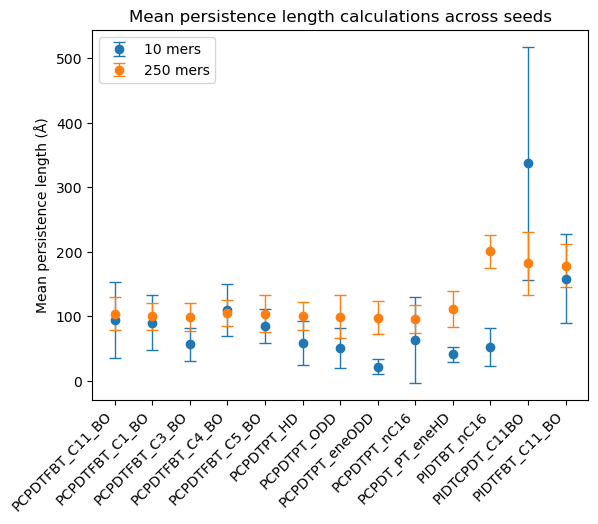

In [57]:
plt.errorbar(x=key_list,y=means,yerr=stdv,label="10 mers",fmt='o',linestyle='none',elinewidth=1,capsize=4)
plt.xticks(ticks=x, labels=key_list, rotation=45, ha='right')
plt.title("Mean persistence length calculations across seeds")
plt.ylabel("Mean persistence length (Å)")
# plt.savefig("stdev",bbox_inches='tight', dpi=600)
plt.errorbar(x=key_list,y=at_1006k,yerr=at_1006k_err, label="250 mers",fmt='o',linestyle='none',elinewidth=1,capsize=4,dash_joinstyle='round')
plt.legend(loc="upper left")
plt.show()

## Prepping for normalcy

In [44]:
print(copy[0].index(min(copy[0])))
print(key_list[0])
print()

12
PCPDTFBT_C11_BO
[94.00151610426431, 90.02926715166274, 56.45048503667994, 109.96911414920388, 85.18734046768763, 58.57215786490043, 50.15619647111218, 21.96808165861622, 63.2179536781707, 40.98381953853293, 52.811138367096476, 337.30306033776776, 158.15391317119492]


In [40]:
from scipy.stats import t

# Parameters
confidence = 0.95
conf_intervals = []

for i, values in enumerate(copy):
    print(values)
    n = len(values)
    mean = np.mean(values)
    std_dev = np.std(values, ddof=1)  # sample std dev
    sem = std_dev / np.sqrt(n)        # standard error of the mean
    
    # t critical value for 95% CI
    t_crit = t.ppf((1 + confidence) / 2, df=n-1)
    
    margin_of_error = t_crit * sem
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error

    conf_intervals.append((ci_lower, ci_upper))

    print(f"Polymer {i+1}: Mean = {mean:.4f}, 95% CI = ({ci_lower:.4f}, {ci_upper:.4f})")

[91.04453387154892, 174.4447934809533, 159.51263728994124, 98.46451805507364, 56.246401099893916, 13.348485219982152, 37.0322643021883, 223.8398450417157, 105.63527443030492, 127.6941616525479, 51.84758903647178, 91.52787350932579, 8.702000375954043, 92.76091996494006, 47.91237844555499, 124.01058189183246]
Polymer 1: Mean = 94.0015, 95% CI = (62.5728, 125.4302)
[43.2941797574285, 140.532269217361, 101.52667960140677, 100.74931487524196, 113.47692640055865, 126.00751053450118, 79.12405764203012, 133.03443781447746, 74.16020520541065, 82.8766278603074, 34.61939760486352, 14.083292466216426, 81.24476740027396, 125.6792918255575, 155.97005634198442, 34.08925987898436]
Polymer 2: Mean = 90.0293, 95% CI = (67.5221, 112.5364)
[32.873381282627264, 47.74222231358319, 39.59426783324447, 34.4358327494914, 33.96580582677796, 34.205137301982035, 68.98459291024031, 107.98841126998008, 34.00928087703795, 83.68639600971476, 30.096894826991264, 60.485439661213576, 52.88251991666888, 87.32359476513062,